In [18]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r'C:\Users\schijven\Documents\Classes\Input_preparation\lib')
from input_preparation_new import Input_prep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from netCDF4 import Dataset
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime, timedelta
from scipy.stats import norm

In [19]:
# all variables in a yaml file
config_filename=r"C:\Users\schijven\Documents\Data\config.yaml"

In [20]:
# started @ 13:17
test = Input_prep(config_filename)
train_data, test_data = test.prepare_input_new()

INFO:root:Reading configuration file C:\Users\schijven\Documents\Data\config.yaml...
INFO:root:Preparing data with clip interval 2001-07-01 00:00:00 - 2018-09-07 23:00:00. Timewindow = 48.
INFO:root:Tide gauge data from Scheveningen loaded and clipped
INFO:root:Altimetry data loaded and clipped
INFO:root:ERA5 data loaded and clipped
100%|██████████| 150719/150719 [44:09<00:00, 56.89it/s]  
INFO:root:Done!
INFO:root:DOT compiled
INFO:root:udist_vlis compiled
INFO:root:udist_schev compiled
INFO:root:udist_eur compiled
INFO:root:vdist_vlis compiled
INFO:root:vdist_schev compiled
INFO:root:vdist_eur compiled
INFO:root:Time compiled
INFO:root:Altimetry data compiled
INFO:root:Altimetry data padded
INFO:root:Altimetry data concatenated
INFO:root:Batched into single batches
INFO:root:Batches merged
INFO:root:Full dataset size: 150672
INFO:root:Training dataset size: 90404
INFO:root:Validation dataset size: 30134
INFO:root:Testing dataset size: 30134
INFO:root:Start normalizing
INFO:root:ERA5 

In [21]:
model_root = Path(r"P:\11207365-eoatsee\Sofie\Data\Saved_models")
model_schev = tf.keras.models.load_model(model_root / "Scheveningen/Scheveningen_full.keras")

In [22]:
for i in test_data:
    print(i)
    break

(<tf.Tensor: shape=(1, 314401), dtype=float32, numpy=
array([[-2.524754  , -2.5282285 , -2.531841  , ...,  0.        ,
         0.        ,  0.24725275]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8763997]], dtype=float32)>)


In [39]:
tg_data = pd.read_csv(r"C:\Users\schijven\Documents\Data\scheveningen-schevngn-nld-rwsHatyan.csv")
tg_data.datetime = pd.to_datetime(tg_data.datetime)
tg_data.set_index("datetime", inplace=True)
tg_data = tg_data[(tg_data.index >= test.start) & (tg_data.index <= test.end)]

train_ratio = test.config["variables"]["train_ratio"]
train_size = int(np.round(len(tg_data)*train_ratio))
t = tg_data.index.values

t_val = t[train_size:]
print(t_val.shape)
print(f"Skip {len(t_val[:-24*365])}, take {24*365}")
# target = tg_data.loc[t_val]
# target["ML"] = y_hat_val.reshape(y_hat_val.shape[0])
# target.reset_index(inplace=True)

(30134,)
Skip 21374, take 8760


In [41]:
test_data_batch = test_data.skip(len(t_val[:-24*365])).take(24*365)

In [42]:
# %%timeit -n 1
y_hat_val = model_schev.predict(test_data_batch)

8760/8760 [==============================] - 206s 6ms/step


In [43]:
model_schev.summary()

Model: "My_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1, 314401)         0         
                                                                 
 dense (Dense)               (None, 1, 32)             10060864  
                                                                 
 dense_1 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 10060897 (38.38 MB)
Trainable params: 10060897 (38.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
target = tg_data.loc[t_val[-24*365:]]
target["ML"] = y_hat_val.reshape(y_hat_val.shape[0])
target.reset_index(inplace=True)

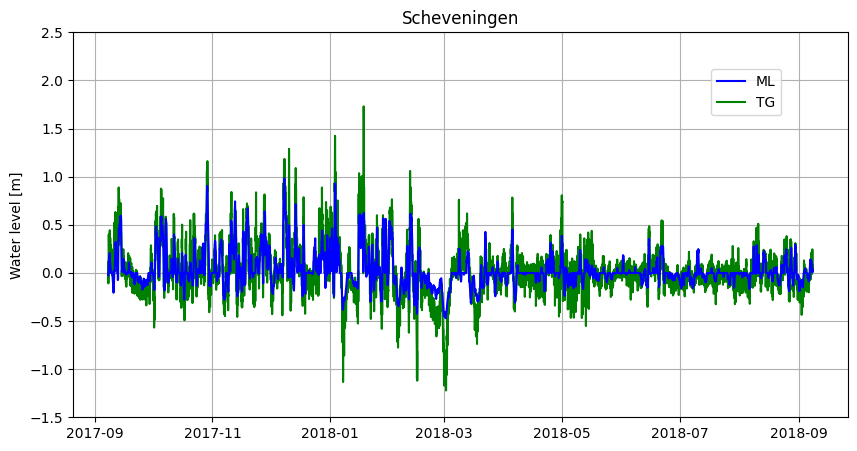

In [45]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)
batch_size = 32
# Create the main figure and axis (left axis)
fig, ax1 = plt.subplots(figsize=(10, 5))

line2 = ax1.plot(target.datetime, target.resid, label='TG', color='green')
line1 = ax1.plot(target.datetime, target.ML, label='ML', color='blue')

ax1.set_ylabel('Water level [m]')
ax1.tick_params(axis='y')

# Combine legend handles and labels
lines = line1 + line2 #+ line3
labels = [line.get_label() for line in lines]

# Create a single legend for both sides in one box
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.84, 0.82))

# Add grid, legends, and title
ax1.grid()
ax1.set_title('Scheveningen')

# Set the x-axis limits
# ax1.set_xlim(times_train[-20] - pd.DateOffset(weeks=8), times_train[-20])
# ax1.set_xlim(target.datetime.values[-200] - pd.DateOffset(weeks=8), target.datetime.values[-200])
# ax1.set_xlim(datetime(2003, 11, 1), datetime(2004, 1, 15))
ax1.set_ylim(-1.5, 2.5)

# Show the plot
plt.show()